# Price Prediction Models


In [1]:
import torch, torchvision, PIL, numpy as np
import pathlib
import PIL
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from tqdm.auto import tqdm
import math
import random
#torch.manual_seed(0)
#np.random.seed(0)
#torch.set_deterministic(True)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_dir = "/content/drive/My Drive/CPEN 291/project/data/"

In [4]:
# Modified from object_detection.ipynb
class PricePredictionDataset:
    def __init__(self, root_dir, use_random=False, transform=None, transform_label=None):
        root_dir = pathlib.Path(root_dir).resolve()
        self.root_dir = root_dir
        self.transform = transform
        self.transform_label = transform_label

        self.labels_f = pd.read_csv(root_dir / 'all_labels_downsampled.csv')

        self.img_names = self.labels_f['name']

        def get_price(fn):
            #fn = str(fn).rsplit('/', 1)[-1]
            fn = str(fn)
            row = self.labels_f.loc[self.labels_f['name'] == fn]
            try:
              index = row.index[0]
            except:
              print(row)
              input()
            return math.log(row['price'][index]) # log because we are scientists

        self.fns_labels = [(imgfn, get_price(imgfn))
                           for imgfn in self.img_names]

    def __len__(self):
        return len(self.fns_labels)

    def __getitem__(self, i):
        if torch.is_tensor(i):
            i = i.item()
        imgfn, label = self.fns_labels[i]
        img = PIL.Image.open(self.root_dir / imgfn)
        img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.transform_label:
            label = self.transform_label(label)
        return (img, label)

In [5]:
# Modified from object_detection.ipynb
def show_img_price(sample):
    img, price = sample
    if torch.is_tensor(img):
        img = img.cpu().permute(1,2,0)
    plt.imshow(img)
    plt.title(math.e**price, color='black') # add color='w' arg if using a dark background
    plt.axis('off')

In [ ]:
dataset_tmp = PricePredictionDataset(dataset_dir)

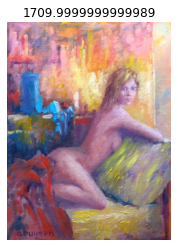

In [ ]:
show_img_price(dataset_tmp[78])

In [ ]:
# Transform for benchmarking model # NOT USED ANYMORE
def randolabo(anything):
  return random.random() * 3 + 6 # log(20000) ~ 9.9, log(1000) ~ 6.9

15055


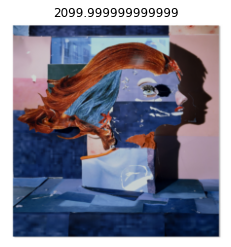

In [7]:
xform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)), torchvision.transforms.ToTensor()])
#dataset_full= PricePredictionDataset(dataset_dir, True, transform=xform)
dataset_full= PricePredictionDataset(dataset_dir, False, transform=xform)
print(len(dataset_full))
show_img_price(dataset_full[102])

In [8]:
n_all= len(dataset_full)
n_used= int(1 * n_all)
n_train= int(0.8 * n_used)
n_test= n_used- n_train
rng= torch.Generator().manual_seed(1910)
dataset_train, dataset_test, _ = torch.utils.data.random_split(dataset_full, [n_train, n_test, n_all-n_train-n_test], rng)
len(dataset_train), len(dataset_test)

(12044, 3011)

In [9]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=False)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False)

In [18]:
pt = True
trim = False
model= torchvision.models.resnet18(pretrained=pt) # complicated models tend to overfit
print(model.fc.in_features) # fc for resnet
#print(model.classifier.in_features) # classifier for densenet
#print(model.classifier[-1].in_features) # classifier[-1] for vgg

#for param in model.parameters():
#  param.requires_grad = False # freeze pretrained layers, otherwise it tends to overfit quickly

# from https://discuss.pytorch.org/t/how-to-delete-layer-in-pretrained-model/17648/2
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
if (trim):
  model.layer3 = Identity();
  model.layer4 = Identity();

# from https://discuss.pytorch.org/t/reset-model-weights/19180/4
def weights_init(m):
  if isinstance(m, torch.nn.Conv2d):
      torch.nn.init.xavier_uniform_(m.weight.data)

if (not pt):
  model.apply(weights_init)
  for child in model.children():
    child.apply(weights_init)
    for c in child.children():
      c.apply(weights_init)
      for h in c.children():
        h.apply(weights_init)
        for i in h.children():
          i.apply(weights_init)


model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 1),
    #torch.nn.Linear(128, 1),

#    torch.nn.ReLU(),
#    torch.nn.Linear(1024, 1024),
#    torch.nn.ReLU(),
#    torch.nn.Linear(1024, 512),
#    torch.nn.ReLU(),
#    torch.nn.Linear(512, 128),
#    torch.nn.ReLU(),
#    torch.nn.Linear(1024, 128),
#    torch.nn.ReLU(),
#    torch.nn.Linear(128, 1)
)
torch.nn.init.xavier_uniform_(model.fc[0].weight)
#torch.nn.init.xavier_uniform_(model.fc[2].weight)
#torch.nn.init.xavier_uniform_(model.classifier[-1][4].weight)
#torch.nn.init.xavier_uniform_(model.classifier[6].weight)
#torch.nn.init.xavier_uniform_(model.classifier[8].weight)
#torch.nn.init.xavier_uniform_(model.classifier[10].weight)


device = torch.device('cuda:0')
model.to(device);


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



512


In [11]:
def run_test(model, criterion, no_preds=False):
    nsamples_test = len(dataset_test)
    loss = 0
    preds = []
    model.eval()
    with torch.no_grad():
        for samples, labels in loader_test:
            samples = samples.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outs = model(samples)
            if not no_preds:
                preds += outs.cpu().unbind()
            loss += criterion(outs, labels) * samples.size(0)
    return loss / nsamples_test, preds

def run_train(model, criterion, opt, sched):
    nsamples_train = len(dataset_train)
    loss_sofar = 0
    model.train()
    with torch.enable_grad():
        for samples, labels in tqdm(loader_train, desc='iters', leave=False):
            samples = samples.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            opt.zero_grad()
            outs = model(samples)
            loss = criterion(outs, labels)
            loss.backward()
            opt.step()
            loss_sofar += loss.item() * samples.size(0)
            if (math.isnan(loss.item())):
              print("loss nan")
              print(loss)
    sched.step()
    return loss_sofar / nsamples_train

def run_all(model, criterion, optimizer, scheduler, n_epochs):
    for epoch in tqdm(range(n_epochs), desc='epochs'):
        loss_train = run_train(model, criterion, optimizer, scheduler)
        loss_test, _ = run_test(model, criterion, no_preds=True)
        tqdm.write(f"epoch {epoch+1}: train loss {loss_train:.4f}, test loss {loss_test:.4f}")
    return loss_test

# Use L1loss to train the model until the loss is low enough to use MSEloss # not used
def marathon(model, criterion0, criterion, optimizer, scheduler, n_epochs):
    crit = criterion0
    for epoch in tqdm(range(n_epochs), desc='epochs'):
        loss_train = run_train(model, crit, optimizer, scheduler)
        loss_test, _ = run_test(model, crit, no_preds=True)
        tqdm.write(f"epoch {epoch+1}: train loss {loss_train:.4f}, test loss {loss_test:.4f}")
        if (loss_train < 0.1 and loss_test < 0.1):
          crit = criterion
    return loss_test


In [19]:
criterion = torch.nn.MSELoss()
# For pretrained
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
# For untrained
if (not pt):
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.1) #, weight_decay=0.1)
  #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1)

In [20]:
run_all(model, criterion, optimizer, scheduler, 10)

epoch 1: train loss 2.4090, test loss 1.3317


epoch 2: train loss 1.2671, test loss 1.2383


epoch 3: train loss 1.2282, test loss 1.2218


epoch 4: train loss 1.2256, test loss 1.2443


epoch 5: train loss 1.2240, test loss 1.1967


epoch 6: train loss 1.2131, test loss 1.1910


epoch 7: train loss 1.2118, test loss 1.1876


epoch 8: train loss 1.2107, test loss 1.1866


epoch 9: train loss 1.2101, test loss 1.1866


epoch 10: train loss 1.2100, test loss 1.1865



tensor(1.1865, device='cuda:0')

In [ ]:
model

model | layers | criterion | optimizer | scheduler | epochs | train loss | test loss | notes
--- | --- | --- | --- | --- |--- | --- | --- | ---
resnet18 | fc=1 linear | MSELoss | SGD, lr=0.01, m=0.1 | StepLR ss=3, gamma=0.1 | 5 | 0.7941 | 0.7835
resnet34 | fc=1 linear | MSELoss | SGD, lr=0.01, m=0.1 | StepLR ss=3, gamma=0.1 | 10 | 0.7889 | 0.7821
resnet50 | fc=1 linear | MSELoss | SGD, lr=0.01, m=0.1 | StepLR ss=3, gamma=0.1 | 10 | 0.7890 | 0.7821
resnet152 | fc=1 linear | MSELoss | SGD, lr=0.01, m=0.1 | StepLR ss=3, gamma=0.1 | 8 | 0.7890 | 0.7821
resnet34 | fc=1 linear | MSELoss | SGD, lr=0.01, m=0.1 | StepLR ss=2, gamma=0.1 | 10 | 1.2243| 1.2007 | downsampled
resnet50 | fc=1 linear | MSELoss | SGD, lr=0.01, m=0.1 | StepLR ss=2, gamma=0.1 | 10 | 1.2489| 1.2218 | downsampled
resnet18 | fc=1 linear | MSELoss | SGD, lr=0.01, m=0.1 | StepLR ss=2, gamma=0.1 | 10 | 1.2100| 1.1865 | downsampled

In [21]:
torch.save(model.state_dict(), '/content/drive/My Drive/CPEN 291/project/sd/model_jared_4_18_v2.pth')
torch.save(optimizer.state_dict(), '/content/drive/My Drive/CPEN 291/project/sd/optim_jared_4_18_v2.pth')
torch.save(scheduler.state_dict(), '/content/drive/My Drive/CPEN 291/project/sd/sched_jared_4_18_v2.pth')

In [ ]:
test_loss, test_preds= run_test(model, criterion)
print(test_loss)

tensor(0.7916, device='cuda:0')


In [ ]:
test_preds[0]

tensor([7.3156])

Prediction     | Real Price


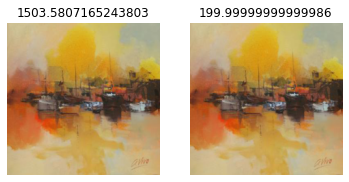

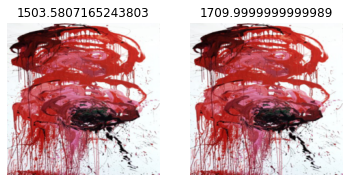

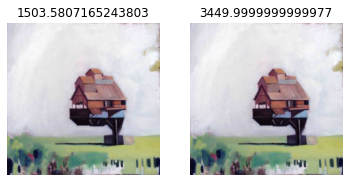

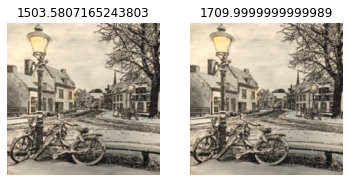

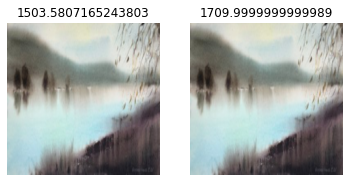

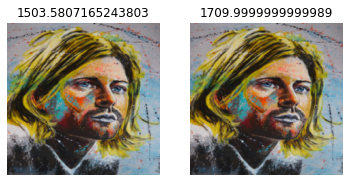

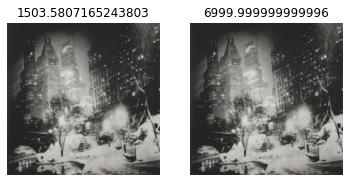

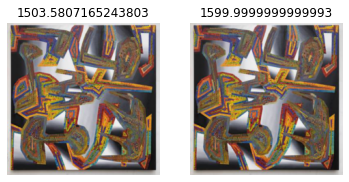

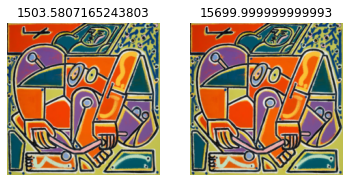

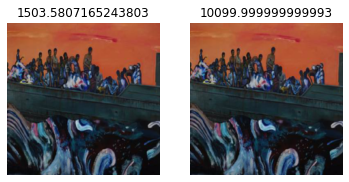

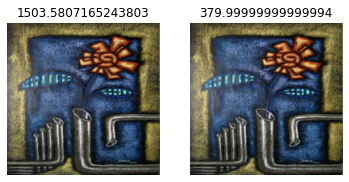

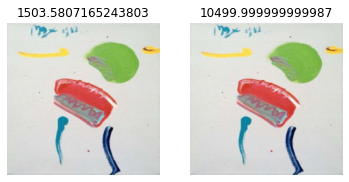

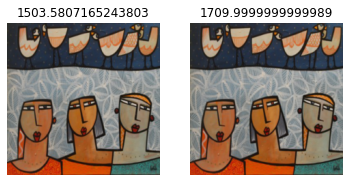

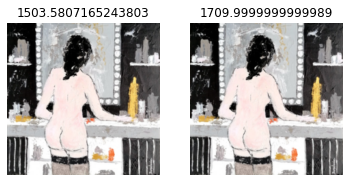

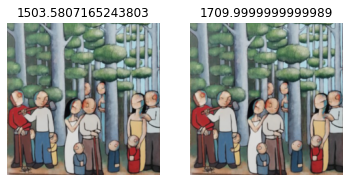

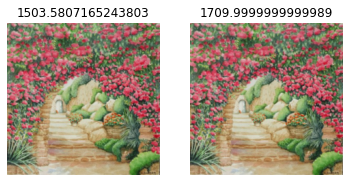

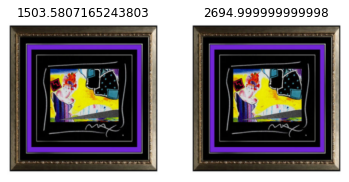

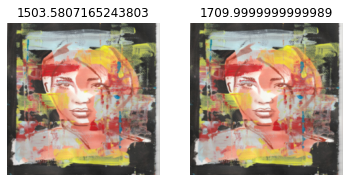

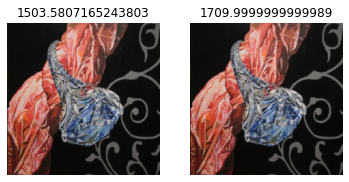

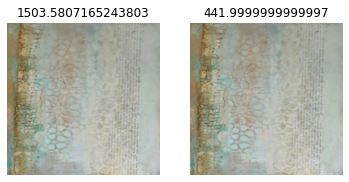

In [ ]:
print("Prediction     | Real Price")
for i in range(20):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    show_img_price((dataset_test[i][0], test_preds[i].item()))
    f.add_subplot(1,2, 2)
    show_img_price(dataset_test[i])
    plt.show(block=True)
